In [1]:
import networkx as nx 
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import random as ra
import time
import pickle
from sklearn.cluster import spectral_clustering as spclustering
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import matplotlib

import sys,os

try:
    from localgraphclustering import *
except:
    # when the package is not installed, import the local version instead. 
    # the notebook must be placed in the original "notebooks/" folder
    sys.path.append("../")
    from localgraphclustering import *

ImportError: Something is wrong with the numpy installation. While importing we detected an older version of numpy in ['/mnt/c/Users/hhelm/.local/lib/python3.6/site-packages/numpy']. One method of fixing this is to repeatedly uninstall numpy until none is found, then reinstall this version.

In [ ]:
# sizes of large clusters
K = 100

# number of clusters and nodes
list_number_of_clusters = [500]
list_number_of_nodes = [10]

# random seed number
random_seed = 20

## Global clustering

In [5]:
start = time.time()

for number_of_nodes in list_number_of_nodes:
    
    print("Nodes in cluster: ", number_of_nodes)
    
    for number_of_clusters in list_number_of_clusters:
        
        # seed number
        seed = random_seed
        ra.seed(seed)
        np.random.seed(seed)
        
        # set parameters
        number_of_large_clusters = 0
        sizes = []
        for i in range(number_of_clusters):
            if i < number_of_large_clusters:
                sizes.append(K)
            else:
                sizes.append(number_of_nodes)
        n = np.sum(sizes)                     
        
        p = 0.5
        q = 3/n
        probs = q * np.ones((number_of_clusters, number_of_clusters)) + (p-q) * np.eye(number_of_clusters) 
        g = nx.generators.community.stochastic_block_model(sizes, probs)
        nx.write_edgelist(g, "sbm.edgelist",data=False)
        g2 = GraphLocal('sbm.edgelist','edgelist',' ') # what is edgelist        

        labels = list(spclustering(g2.adjacency_matrix, n_clusters=number_of_clusters, eigen_solver='arpack'))
        
        labels_true = []
        for i in range(number_of_clusters):
            for j in range(sizes[i]):
                labels_true.append(i)

        print("Number of clusters: ", number_of_clusters, " p: ", p, " q: ", q," ARI: ", adjusted_rand_score(labels, labels_true))
        
        #break
    #break
end = time.time()
print('Time: ', end - start)    

Nodes in cluster:  10
Number of clusters:  500  p:  0.5  q:  0.0006  ARI:  0.8549025709482234
Time:  102.55535101890564


## Global + KMeans

In [8]:
start = time.time()
from sklearn.manifold import spectral_embedding as spembedding
sp_emb = spembedding(g2.adjacency_matrix, n_components=number_of_clusters, eigen_solver='arpack', norm_laplacian=True, drop_first=True)
end = time.time()
print('Time: ', end - start)   

Time:  55.11201596260071


In [ ]:
from sklearn.cluster import KMeans

start = time.time()
clustering_kmeans = KMeans(n_clusters=number_of_clusters).fit(sp_emb)
labels_sp = clustering_kmeans.labels_
end = time.time()
print('Time: ', end - start)   

In [ ]:
print("Number of clusters: ", number_of_clusters, " p: ", p, " q: ", q," ARI: ", adjusted_rand_score(labels_sp, labels_true))

visualization

In [129]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(sp_emb)

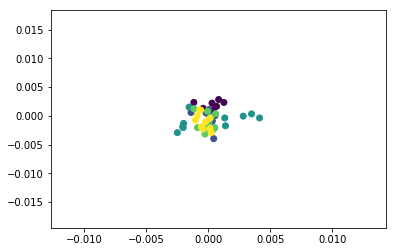

In [130]:
plt.scatter(principalComponents[:50,0], principalComponents[:50,1], c=labels_true[:50])

## Node2Vec

In [213]:
node2vec = np.loadtxt('./datasets/sbm.emb', dtype = 'float',delimiter=' ', skiprows=1)
print(node2vec.shape)

(5000, 501)


In [214]:
sorted_idx = np.argsort(node2vec[:,0])
node2vec_emb = node2vec[sorted_idx,:][:,1:]

In [215]:
print(node2vec_emb.shape)

(5000, 500)


In [216]:
start = time.time()
clustering_kmeans = KMeans(n_clusters=number_of_clusters).fit(node2vec_emb)
labels_node2vec = clustering_kmeans.labels_
end = time.time()
print('Time: ', end - start)   

Time:  49.454301834106445


In [217]:
print("Number of clusters: ", number_of_clusters, " p: ", p, " q: ", q," ARI: ", adjusted_rand_score(labels_node2vec, labels_true))

Number of clusters:  500  p:  0.5  q:  0.0006  ARI:  0.9097101711081506


visualization

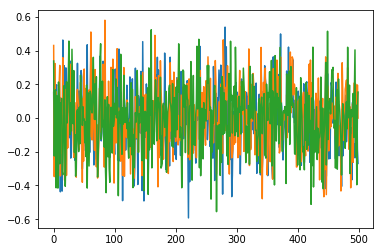

In [246]:
plt.plot(node2vec_emb[0,:])
plt.plot(node2vec_emb[1,:])
plt.plot(node2vec_emb[100,:])

In [218]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(sp_emb)

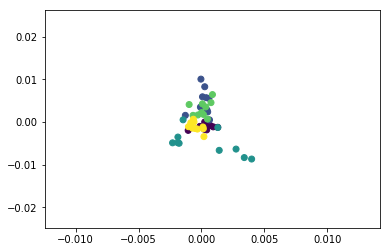

In [219]:
plt.scatter(principalComponents[:50,0], principalComponents[:50,1], c=labels_true[:50])

## Local clustering

In [158]:
start = time.time()

for number_of_nodes in list_number_of_nodes:
    
    print("Nodes in cluster: ", number_of_nodes)
    
    for number_of_clusters in list_number_of_clusters:
        
        # seed number
        seed = random_seed
        ra.seed(seed)
        np.random.seed(seed)     
        
        # set parameters
        number_of_large_clusters = 0
        sizes = []
        for i in range(number_of_clusters):
            if i < number_of_large_clusters:
                sizes.append(K)
            else:
                sizes.append(number_of_nodes)
        n = np.sum(sizes)          
                
        probs = q * np.ones((number_of_clusters, number_of_clusters)) + (p-q) * np.eye(number_of_clusters) 
        g = nx.generators.community.stochastic_block_model(sizes, probs)
        nx.write_edgelist(g, "sbm.edgelist",data=False)
        g2 = GraphLocal('sbm.edgelist','edgelist',' ') # what is edgelist

        # alpha
        alpha = 0.1
        
        # compute upper- and lower bounds of rho
        numerator   = q*(1-alpha)
        avg_d       = p*number_of_nodes + q*(n - number_of_nodes)
        denominator = 2*alpha*avg_d*avg_d + q*(1-alpha)*(number_of_nodes*avg_d + (n - number_of_nodes)*avg_d)
        rho_down = numerator/denominator
        
        numerator   = p*(1-alpha)
        denominator = avg_d*((1+alpha)*avg_d + (1-alpha)*p)
        rho_up = numerator/denominator
        
        # compute all embeddings and distances
        embeddings = compute_all_embeddings(g2,rho_list=[rho_down/3,rho_up/0.5],alpha_list=[0.03,0.1],nsamples_from_rho=10,nsamples_from_alpha=5,epsilon=1e-2,njobs=6)
        X = normalize_embeddings(g2,embeddings, norm_type = 2)
#         Y = normalize_embeddings(g2,embeddings, norm_type = 1)
        Z_X = pairwise_distances(X, metric='l2', n_jobs=6)        
#         Z_Y = pairwise_distances(Y, metric='l1', n_jobs=1)      
        
        labels_X = compute_clusters_given_distance(nclusters=number_of_clusters,Z=Z_X)
#         labels_Y = compute_clusters_given_distance(nclusters=number_of_clusters,Z=Z_Y)
        
        labels_true = []
        for i in range(number_of_clusters):
            for j in range(sizes[i]):
                labels_true.append(i)            
        
        print("Number of clusters: ", number_of_clusters, " p: ", p, " q: ", q," ARI: ", adjusted_rand_score(labels_X, labels_true), "(l2-norm)")
#         print("Number of clusters: ", number_of_clusters, " p: ", p, " q: ", q," ARI: ", adjusted_rand_score(labels_Y, labels_true), "(l1-norm)")

end = time.time()
print('Time: ', end - start) 

Nodes in cluster:  10
Number of clusters:  500  p:  0.5  q:  0.0006  ARI:  0.9315223955078288 (l2-norm)
Time:  1632.4126482009888


In [242]:
print(np.linalg.norm(X[0,:].toarray().reshape(-1) - X[2,:].toarray().reshape(-1)))
print(np.linalg.norm(X[0,:].toarray().reshape(-1) - X[160,:].toarray().reshape(-1)))

1.3489329384675237
1.4140356371347156


In [253]:
(np.linalg.norm(X[0,:].toarray().reshape(-1) @ X[2,:].toarray().reshape(-1)))
(np.linalg.norm(X[0,:].toarray().reshape(-1) @ X[2,:].toarray().reshape(-1)))

0.09018996375868592

In [255]:
H = X.T @ X

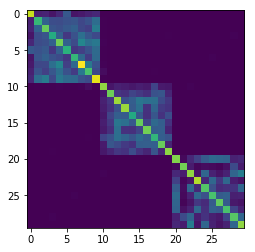

In [257]:
plt.imshow(H[:30,:30].toarray())

In [243]:
from scipy.stats import entropy
print(entropy(X[0,:].toarray().reshape(-1), X1[2,:].toarray().reshape(-1)))
print(entropy(X[0,:].toarray().reshape(-1), X1[160,:].toarray().reshape(-1)))



inf
inf


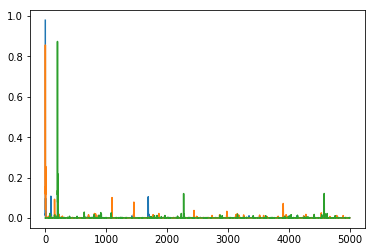

In [245]:
plt.plot(X[0,:].toarray().reshape(-1))
plt.plot(X[1,:].toarray().reshape(-1))
plt.plot(X[200,:].toarray().reshape(-1))

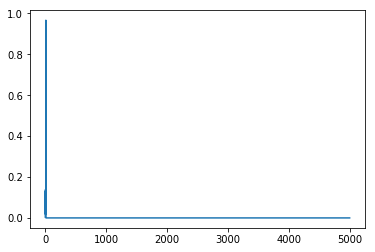

In [163]:
plt.plot(X[9,:].toarray().reshape(-1))

visualization

In [239]:
embeddings[0]

(array([   0,    1,    2, ..., 4993, 4998, 4999], dtype=uint32),
 array([5.05294867e-02, 8.30399782e-04, 1.03905313e-03, ...,
        8.50645241e-06, 8.54957009e-07, 9.82298621e-07]))

In [240]:
sum_ = 0
JA = [0]
IA = []
A  = []
for data in embeddings:
    vec = data[1]/np.linalg.norm(data[1],1)
    how_many = len(data[0])
    sum_ += how_many
    JA.append(sum_)
    IA.extend(list(data[0]))
    A.extend(list(vec))
X1 = sp.sparse.csc_matrix((A, IA, JA), shape=(n, n))    

In [142]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X.toarray())

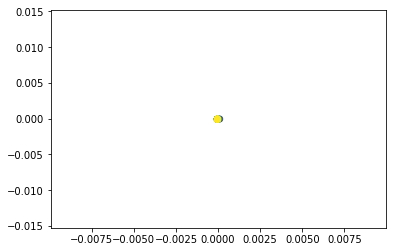

In [143]:
plt.scatter(principalComponents[:50,0], principalComponents[:50,1], c=labels_true[:50])

In [224]:
dist = []
for i in range(n):
    dist.append(np.linalg.norm(X[0,:].toarray()) - np.linalg.norm(X[i,:].toarray()))

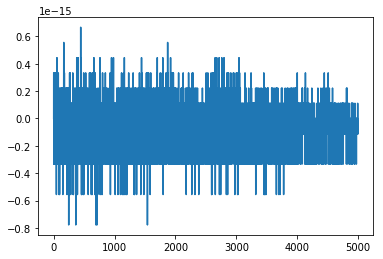

In [225]:
plt.plot(dist)

In [ ]:
# start = time.time()

# for number_of_nodes in list_number_of_nodes:
    
#     print("Nodes in cluster: ", number_of_nodes)
    
#     for number_of_clusters in list_number_of_clusters:
        
#         # seed number
#         seed = random_seed
#         ra.seed(seed)
#         np.random.seed(seed)     
        
#         # set parameters
#         number_of_large_clusters = 0
#         sizes = []
#         for i in range(number_of_clusters):
#             if i < number_of_large_clusters:
#                 sizes.append(K)
#             else:
#                 sizes.append(number_of_nodes)
#         n = np.sum(sizes)          
                
#         probs = q * np.ones((number_of_clusters, number_of_clusters)) + (p-q) * np.eye(number_of_clusters) 
#         g = nx.generators.community.stochastic_block_model(sizes, probs)
#         nx.write_edgelist(g, "sbm.edgelist",data=False)
#         g2 = GraphLocal('sbm.edgelist','edgelist',' ') # what is edgelist
        
#         # embedding matrices
#         X = np.zeros((n,n))
#         Y = np.zeros((n,n))
        
#         # alpha
#         alpha = 0.05
        
#         # compute upper- and lower bounds of rho
#         numerator   = q*(1-alpha)
#         avg_d       = p*number_of_nodes + q*(n - number_of_nodes)
#         denominator = 2*alpha*avg_d*avg_d + q*(1-alpha)*(number_of_nodes*avg_d + (n - number_of_nodes)*avg_d)
#         rho_down = numerator/denominator
        
#         numerator   = p*(1-alpha)
#         denominator = avg_d*((1+alpha)*avg_d + (1-alpha)*p)
#         rho_up = numerator/denominator
        
#         for node in range(n):
            
#             ref_node = [node]
            
#             n_samples = 500
#             rho_list = list(np.linspace(rho_down/3, rho_up/0.5, n_samples, endpoint=True))

#             min_crit = 10000
#             min_crit_embedding = 0
            
#             warm_start = list(np.zeros(n))
            
#             for rho in list(reversed(rho_list)):
                
#                 output = approximate_PageRank(g2,ref_node,method = "l1reg-rand",alpha=alpha,rho=rho,normalize=False,normalized_objective=False,epsilon=1.0e-10,iterations=10000,ys=warm_start) 
                
#                 conductance = g2.compute_conductance(output[0])
           
#                 warm_start = np.zeros(n)
#                 warm_start[output[0]] = output[1]
#                 warm_start = list(warm_start)
                
#                 crit = conductance
#                 if crit <= min_crit:
#                     min_crit = crit
#                     min_crit_embedding = output

#             X[node,min_crit_embedding[0]] = min_crit_embedding[1]/np.linalg.norm(min_crit_embedding[1],2)
#             Y[node,min_crit_embedding[0]] = min_crit_embedding[1]/np.linalg.norm(min_crit_embedding[1],1)

#         Z_X = pairwise_distances(X, metric='l2', n_jobs=4)
#         Z_Y = pairwise_distances(Y, metric='l1', n_jobs=4)
        
#         labels_X = compute_clusters_given_distance(nclusters=number_of_clusters,Z=Z_X)
#         labels_Y = compute_clusters_given_distance(nclusters=number_of_clusters,Z=Z_Y)
        
#         labels_true = []
#         for i in range(number_of_clusters):
#             for j in range(sizes[i]):
#                 labels_true.append(i)            
        
#         print("Number of clusters: ", number_of_clusters, " p: ", p, " q: ", q," ARI: ", adjusted_rand_score(labels_X, labels_true), "(l2-norm)")
#         print("Number of clusters: ", number_of_clusters, " p: ", p, " q: ", q," ARI: ", adjusted_rand_score(labels_Y, labels_true), "(l1-norm)")

# end = time.time()
# print('Time: ', end - start) 